In [ ]:
# Import libraries yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import sklearn

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model # type: ignore
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore

# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Import libraries berhasil")
print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"NumPy version: {np.__version__}")

Import libraries berhasil
TensorFlow version: 2.20.0
Pandas version: 2.3.3
Scikit-learn version: 1.7.2
NumPy version: 2.3.4


In [ ]:
# Load semua dataset
def load_project_data():
    """Memuat semua file CSV yang terkait dengan proyek"""
    try:
        # Load datasets utama
        allocations = pd.read_csv('/xampp/htdocs/project_wise/project_wise/project-prediction-app-main/data/raw/allocations.csv')
        projects = pd.read_csv('/xampp/htdocs/project_wise/project-prediction-app-main/data/raw/team_members.csv')
        risks = pd.read_csv('/xampp/htdocs/project_wise/project-prediction-app-main/data/raw/risks.csv')
        project_technologies = pd.read_csv('/xampp/htdocs/project_wise/project-prediction-app-main/data/raw/project_technologies.csv')
        
        # Load datasets referensi
        expertise_levels = pd.read_csv('/xampp/htdocs/project_wise/project-prediction-app-main/data/raw/expertise_levels.csv')
        sdlc_methods = pd.read_csv('/xampp/htdocs/project_wise/project-prediction-app-main/data/raw/sdlc_methods.csv')
        risk_categories = pd.read_csv('/xampp/htdocs/project_wise/project-prediction-app-main/data/raw/risk_categories.csv')
        risk_types = pd.read_csv('/xampp/htdocs/project_wise/project-prediction-app-main/data/raw/risk_types.csv')
        technology_types = pd.read_csv('/xampp/htdocs/project_wise/project-prediction-app-main/data/raw/technology_types.csv')
        
        print("Load data berhasil")
        print(f"Jumlah data projects: {len(projects)}")
        print(f"Jumlah data allocations: {len(allocations)}")
        print(f"Jumlah data team_members: {len(team_members)}") # type: ignore
        print(f"Jumlah data risks: {len(risks)}")
        print(f"Jumlah data project_technologies: {len(project_technologies)}")
        
        return {
            'allocations': allocations,
            'projects': projects,
            'team_members': team_members, # type: ignore
            'risks': risks,
            'project_technologies': project_technologies,
            'expertise_levels': expertise_levels,
            'sdlc_methods': sdlc_methods,
            'risk_categories': risk_categories,
            'risk_types': risk_types,
            'technology_types': technology_types
        }
        
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Load data
data_dict = load_project_data()

if data_dict:
    # Tampilkan preview dari setiap dataset
    print("\nPreview datasets:")
    for name, df in data_dict.items():
        print(f"\n{name}.csv - Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print(f"Sample data:")
        print(df.head(2))
        print("-" * 50)

Load data berhasil
Jumlah data projects: 500
Jumlah data allocations: 500
Jumlah data team_members: 1817
Jumlah data risks: 1364
Jumlah data project_technologies: 1817

Preview datasets:

allocations.csv - Shape: (500, 9)
Columns: ['id', 'project_id', 'sdlc_method_id', 'duration_months', 'total_development_cost', 'additional_costs', 'status', 'created_at', 'last_updated_at']
Sample data:
   id  project_id  sdlc_method_id  duration_months  total_development_cost  \
0   1           1               2               17              3250000000   
1   2           2               3               10              1250000000   

   additional_costs    status created_at last_updated_at  
0         250000000  archived  1/10/2015       1/12/2015  
1         100000000  archived  2/25/2015        3/2/2015  
--------------------------------------------------

projects.csv - Shape: (500, 9)
Columns: ['id', 'name', 'type_project', 'scale', 'start_date', 'end_date', 'status_project', 'created_at', 'last_u

In [ ]:
# Data preprocessing dan feature engineering
print("Memulai Data Preprocessing dan Feature Engineering...")

# Ambil datasets utama
allocations = data_dict['allocations']
projects = data_dict['projects']
team_members = data_dict['team_members']
risks = data_dict['risks']
project_technologies = data_dict['project_technologies']

# Cek struktur data terlebih dahulu
print("Struktur data allocations:")
print(allocations.columns.tolist())
print("\nStruktur data projects:")
print(projects.columns.tolist())
print("\nStruktur data team_members:")
print(team_members.columns.tolist())

# 1. Preprocessing data projects
print("\n1. Preprocessing data projects...")
projects['start_date'] = pd.to_datetime(projects['start_date'])
projects['end_date'] = pd.to_datetime(projects['end_date'])
projects['actual_duration'] = (projects['end_date'] - projects['start_date']).dt.days / 30  # dalam bulan

# 2. Aggregasi data team members per project
print("2. Aggregasi data team members...")
# Gabungkan team_members dengan allocations untuk mendapatkan project_id
team_with_project = team_members.merge(allocations[['id', 'project_id']], 
                                      left_on='allocation_id', right_on='id', 
                                      how='left', suffixes=('', '_alloc'))

team_agg = team_with_project.groupby('project_id').agg({
    'quantity': 'sum',
    'expertise_level_id': ['mean', 'max'],
    'avg_salary': 'mean'
}).reset_index()

# Flatten column names
team_agg.columns = ['project_id', 'total_team_size', 'avg_expertise', 'max_expertise', 'avg_salary']

# 3. Aggregasi data risks per project
print("3. Aggregasi data risks...")
risk_agg = risks.groupby('project_id').agg({
    'id': 'count',  # jumlah risks
    'impact_level': lambda x: (x == 'high').sum(),  # jumlah high impact risks
    'likelihood': lambda x: (x == 'high').sum()  # jumlah high likelihood risks
}).reset_index()
risk_agg.columns = ['project_id', 'total_risks', 'high_impact_risks', 'high_likelihood_risks']

# 4. Aggregasi data technologies per project
print("4. Aggregasi data technologies...")
tech_agg = project_technologies.groupby('project_id').agg({
    'technology_type_id': 'nunique',  # jumlah jenis teknologi berbeda
    'tool_name': 'count'  # total tools digunakan
}).reset_index()
tech_agg.columns = ['project_id', 'unique_tech_types', 'total_tools']

# 5. Gabungkan semua data
print("5. Menggabungkan semua data...")
# Gabungkan projects dengan allocations
merged_data = projects.merge(allocations, left_on='id', right_on='project_id', how='left', suffixes=('_proj', '_alloc'))

# Gabungkan dengan data aggregasi lainnya
merged_data = merged_data.merge(team_agg, on='project_id', how='left')
merged_data = merged_data.merge(risk_agg, on='project_id', how='left')
merged_data = merged_data.merge(tech_agg, on='project_id', how='left')

print(f"Shape setelah merge: {merged_data.shape}")

# 6. Handle missing values
print("6. Handling missing values...")
merged_data['total_risks'] = merged_data['total_risks'].fillna(0)
merged_data['high_impact_risks'] = merged_data['high_impact_risks'].fillna(0)
merged_data['high_likelihood_risks'] = merged_data['high_likelihood_risks'].fillna(0)
merged_data['unique_tech_types'] = merged_data['unique_tech_types'].fillna(0)
merged_data['total_tools'] = merged_data['total_tools'].fillna(0)
merged_data['total_team_size'] = merged_data['total_team_size'].fillna(0)
merged_data['avg_expertise'] = merged_data['avg_expertise'].fillna(0)
merged_data['max_expertise'] = merged_data['max_expertise'].fillna(0)
merged_data['avg_salary'] = merged_data['avg_salary'].fillna(0)

# 7. Buat target variable (klasifikasi status proyek)
print("7. Membuat target variable...")
merged_data['project_success'] = (merged_data['status_project'] == 'success').astype(int)

# 8. Pilih features untuk modeling
print("8. Memilih features untuk modeling...")
features = [
    'duration_months', 'total_development_cost', 'additional_costs',
    'total_team_size', 'avg_expertise', 'max_expertise', 'avg_salary',
    'total_risks', 'high_impact_risks', 'high_likelihood_risks',
    'unique_tech_types', 'total_tools', 'scale', 'type_project', 'sdlc_method_id'
]

# Data final untuk modeling
model_data = merged_data[features + ['project_success']].copy()

print(f"\nData final shape: {model_data.shape}")
print(f"Jumlah features: {len(features)}")
print(f"Distribusi target variable:")
print(model_data['project_success'].value_counts())
print(f"Persentase success: {model_data['project_success'].mean():.2%}")

# Tampilkan statistik deskriptif
print("\nStatistik deskriptif data numerik:")
print(model_data.describe())

# Cek missing values final
print("\nMissing values final:")
print(model_data.isnull().sum())

Memulai Data Preprocessing dan Feature Engineering...
Struktur data allocations:
['id', 'project_id', 'sdlc_method_id', 'duration_months', 'total_development_cost', 'additional_costs', 'status', 'created_at', 'last_updated_at']

Struktur data projects:
['id', 'name', 'type_project', 'scale', 'start_date', 'end_date', 'status_project', 'created_at', 'last_updated_at', 'actual_duration']

Struktur data team_members:
['id', 'allocation_id', 'role', 'quantity', 'expertise_level_id', 'avg_salary', 'created_at', 'last_updated_at']

1. Preprocessing data projects...
2. Aggregasi data team members...
3. Aggregasi data risks...
4. Aggregasi data technologies...
5. Menggabungkan semua data...
Shape setelah merge: (500, 28)
6. Handling missing values...
7. Membuat target variable...
8. Memilih features untuk modeling...

Data final shape: (500, 16)
Jumlah features: 15
Distribusi target variable:
project_success
0    270
1    230
Name: count, dtype: int64
Persentase success: 46.00%

Statistik desk

Memulai Data Preparation dan Split Dataset...
1. Encoding categorical variables...
2. Memilih final features...
Total features: 24
Numerical features: 14
Categorical features: 10
3. Splitting dataset...
Training set: (400, 44)
Test set: (100, 44)
Training target distribution: {0: 216, 1: 184}
Test target distribution: {0: 54, 1: 46}
4. Feature scaling...
X_train scaled shape: (400, 44)
X_test scaled shape: (100, 44)
5. Visualisasi distribusi data...


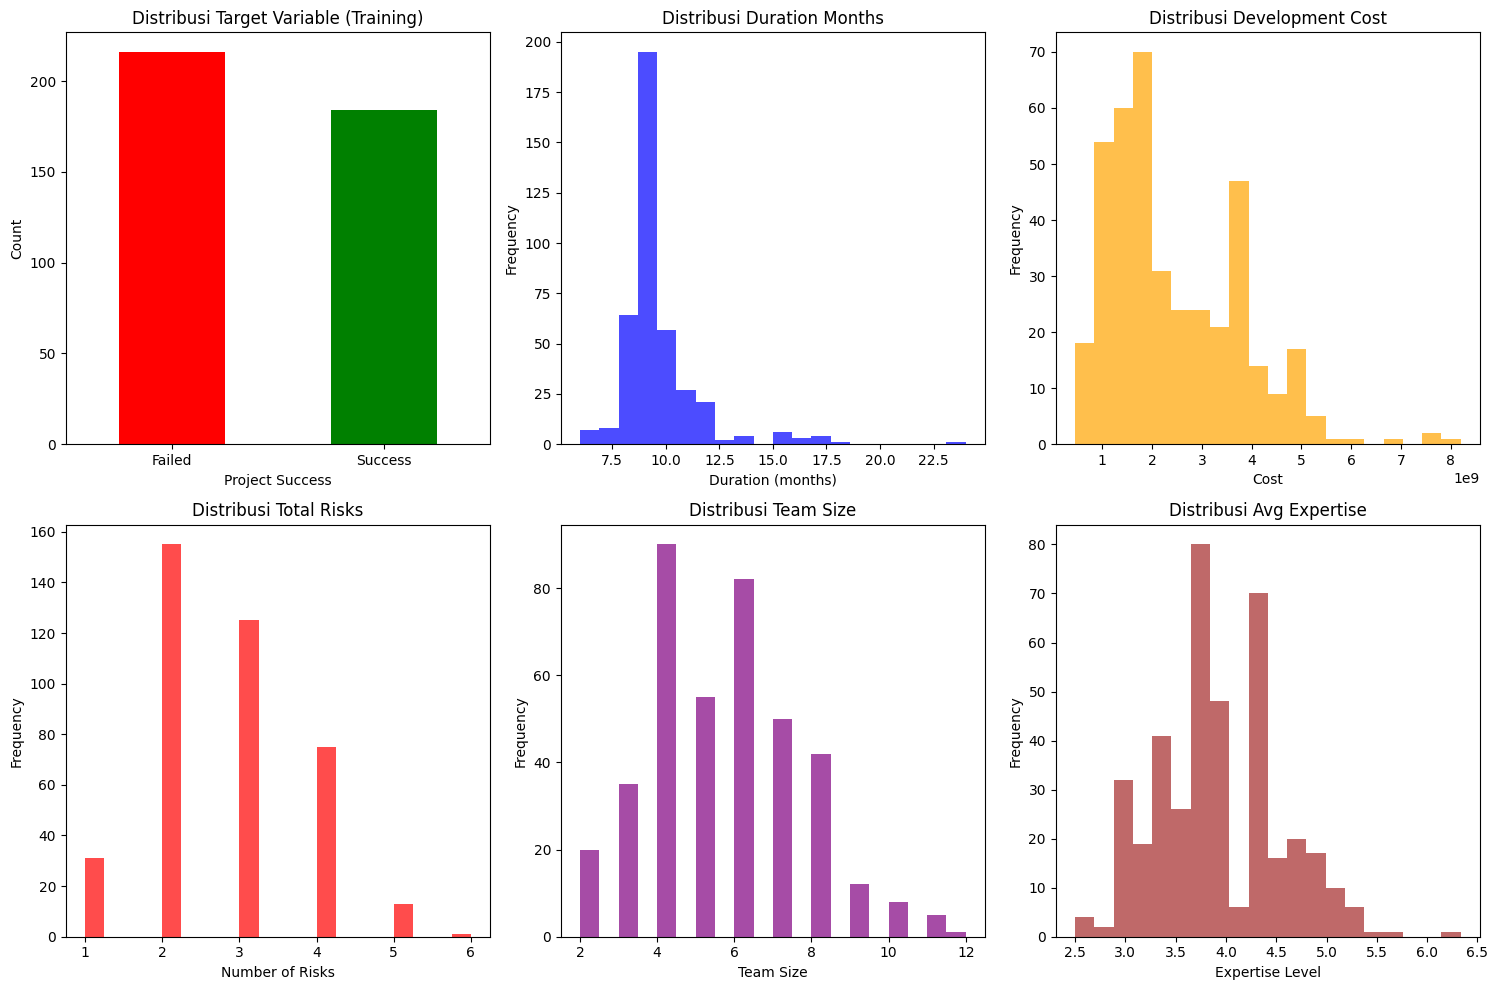

6. Analisis korelasi features numerik...


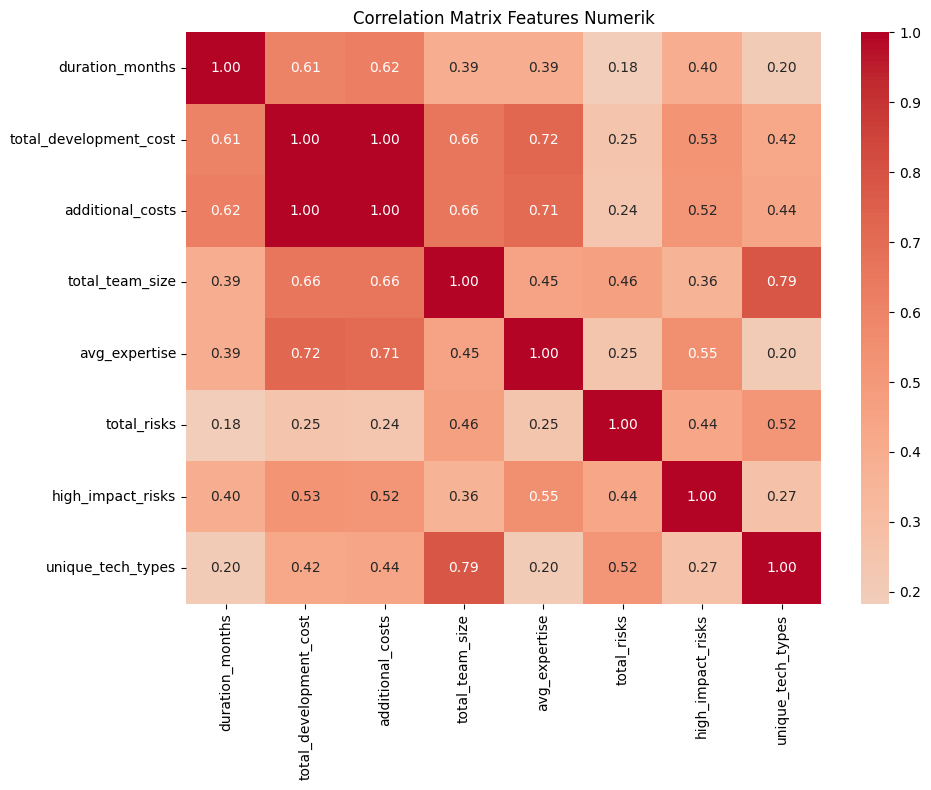


Data preparation selesai!
Dataset siap untuk modeling hybrid machine learning


In [8]:
# Data preparation dan split dataset
print("Memulai Data Preparation dan Split Dataset...")

# 1. Encoding categorical variables
print("1. Encoding categorical variables...")

# Label encoding untuk scale
scale_mapping = {'low': 0, 'medium': 1, 'high': 2}
model_data['scale_encoded'] = model_data['scale'].map(scale_mapping)

# One-hot encoding untuk type_project
type_project_dummies = pd.get_dummies(model_data['type_project'], prefix='type')
model_data = pd.concat([model_data, type_project_dummies], axis=1)

# 2. Pilih final features untuk modeling
print("2. Memilih final features...")
numerical_features = [
    'duration_months', 'total_development_cost', 'additional_costs',
    'total_team_size', 'avg_expertise', 'max_expertise', 'avg_salary',
    'total_risks', 'high_impact_risks', 'high_likelihood_risks',
    'unique_tech_types', 'total_tools', 'sdlc_method_id', 'scale_encoded'
]

categorical_features = [col for col in type_project_dummies.columns]

final_features = numerical_features + categorical_features
X = model_data[final_features]
y = model_data['project_success']

print(f"Total features: {len(final_features)}")
print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

# 3. Split dataset
print("3. Splitting dataset...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training target distribution: {y_train.value_counts().to_dict()}")
print(f"Test target distribution: {y_test.value_counts().to_dict()}")

# 4. Feature scaling
print("4. Feature scaling...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train scaled shape: {X_train_scaled.shape}")
print(f"X_test scaled shape: {X_test_scaled.shape}")

# 5. Visualisasi distribusi features
print("5. Visualisasi distribusi data...")
plt.figure(figsize=(15, 10))

# Distribusi target variable
plt.subplot(2, 3, 1)
y_train.value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Distribusi Target Variable (Training)')
plt.xlabel('Project Success')
plt.ylabel('Count')
plt.xticks([0, 1], ['Failed', 'Success'], rotation=0)

# Distribusi duration months
plt.subplot(2, 3, 2)
plt.hist(X_train['duration_months'], bins=20, alpha=0.7, color='blue')
plt.title('Distribusi Duration Months')
plt.xlabel('Duration (months)')
plt.ylabel('Frequency')

# Distribusi total development cost
plt.subplot(2, 3, 3)
plt.hist(X_train['total_development_cost'], bins=20, alpha=0.7, color='orange')
plt.title('Distribusi Development Cost')
plt.xlabel('Cost')
plt.ylabel('Frequency')

# Distribusi total risks
plt.subplot(2, 3, 4)
plt.hist(X_train['total_risks'], bins=20, alpha=0.7, color='red')
plt.title('Distribusi Total Risks')
plt.xlabel('Number of Risks')
plt.ylabel('Frequency')

# Distribusi team size
plt.subplot(2, 3, 5)
plt.hist(X_train['total_team_size'], bins=20, alpha=0.7, color='purple')
plt.title('Distribusi Team Size')
plt.xlabel('Team Size')
plt.ylabel('Frequency')

# Distribusi expertise level
plt.subplot(2, 3, 6)
plt.hist(X_train['avg_expertise'], bins=20, alpha=0.7, color='brown')
plt.title('Distribusi Avg Expertise')
plt.xlabel('Expertise Level')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 6. Correlation matrix untuk features numerik utama
print("6. Analisis korelasi features numerik...")
numeric_features_for_corr = [
    'duration_months', 'total_development_cost', 'additional_costs',
    'total_team_size', 'avg_expertise', 'total_risks', 
    'high_impact_risks', 'unique_tech_types'
]

correlation_matrix = X_train[numeric_features_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix Features Numerik')
plt.tight_layout()
plt.show()

print("\nData preparation selesai!")
print(f"Dataset siap untuk modeling hybrid machine learning")

Memulai Training Gradient Boosting sebagai Feature Extractor...
1. Training Gradient Boosting model...
2. Debug Feature Importance...
Panjang final_features: 44
Panjang feature_importances_: 44
Shape X_train_scaled: (400, 44)
3. Analisis Feature Importance...
Top 10 Feature Importance:
       feature  importance
4    feature_4    0.149769
6    feature_6    0.128383
12  feature_12    0.087193
1    feature_1    0.062768
9    feature_9    0.057197
2    feature_2    0.056201
0    feature_0    0.054195
5    feature_5    0.045933
3    feature_3    0.026993
19  feature_19    0.025153


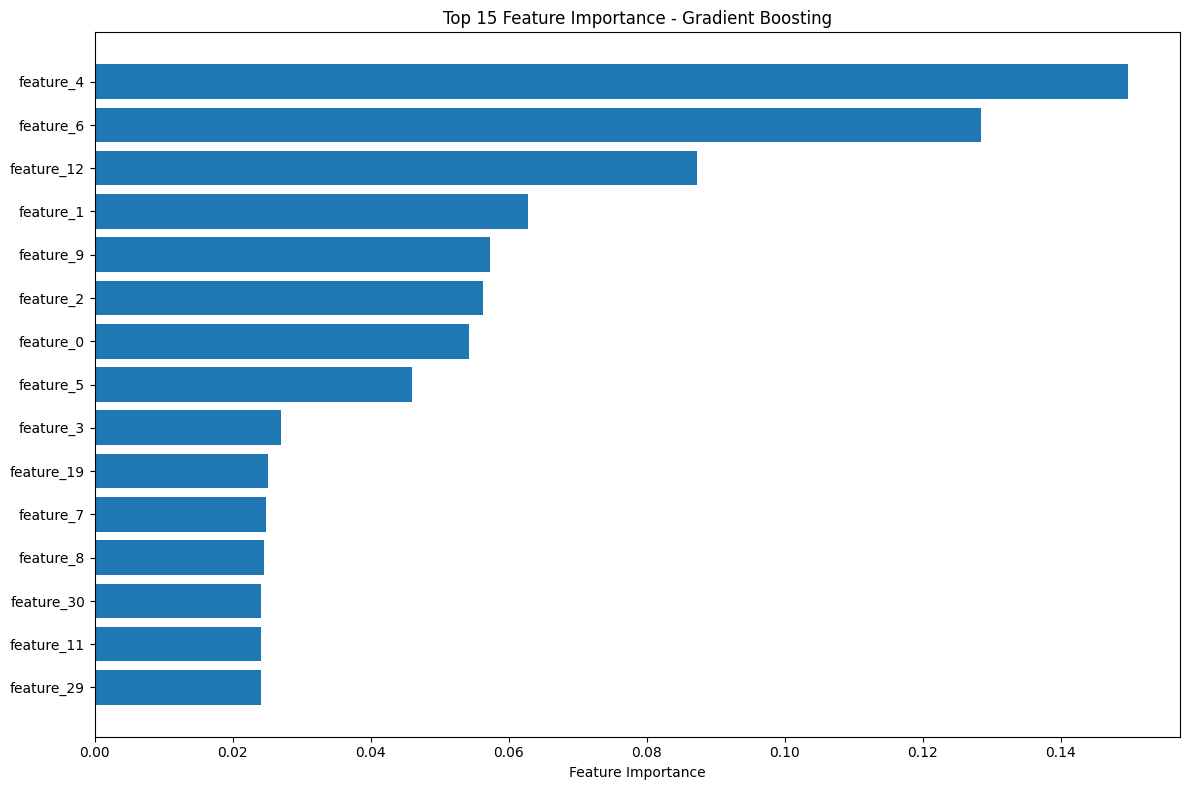

4. Feature Selection menggunakan SelectFromModel...
Jumlah features sebelum selection: 44
Jumlah features setelah selection: 22
Selected features: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_15', 'feature_17', 'feature_19', 'feature_27', 'feature_29', 'feature_30', 'feature_33', 'feature_34', 'feature_40']
5. Evaluasi Gradient Boosting dengan Metrik Lengkap...
Gradient Boosting Performance:
Accuracy: 0.8100
Precision: 0.8140
Recall: 0.7609
F1-Score: 0.7865
ROC-AUC: 0.9082


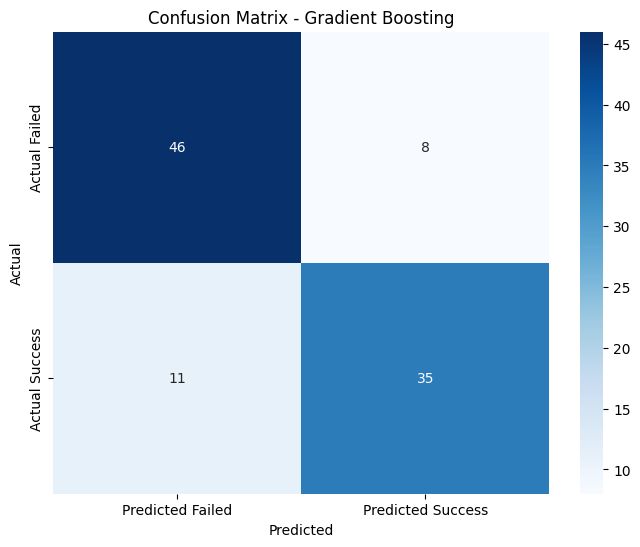

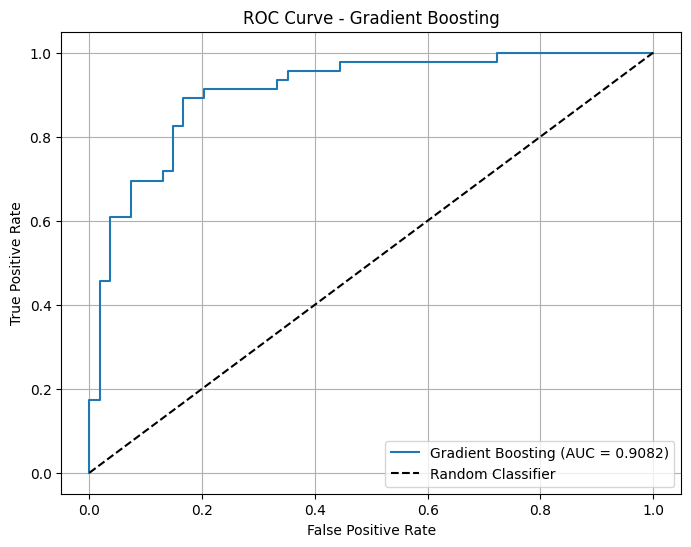

6. Menyiapkan feature representations untuk model hybrid...

Gradient Boosting feature extraction selesai!
Selected features akan digunakan untuk input ANN dan Naive Bayes


In [14]:
# ==========================================
# Gradient Boosting sebagai Feature Extractor
# ==========================================
print("Memulai Training Gradient Boosting sebagai Feature Extractor...")

# --- 0. Sinkronisasi nama fitur dengan data yang telah diproses ---
# Jika X_train_scaled berbentuk DataFrame, gunakan kolomnya langsung
# Jika berbentuk numpy array, buat nama fitur otomatis
if isinstance(X_train_scaled, pd.DataFrame):
    feature_names = X_train_scaled.columns.tolist()
else:
    feature_names = [f"feature_{i}" for i in range(X_train_scaled.shape[1])]

# Update final_features agar sama panjang
final_features = feature_names

# --- 1. Training Gradient Boosting ---
print("1. Training Gradient Boosting model...")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)

# --- 2. Debug Feature Importance ---
print("2. Debug Feature Importance...")
print(f"Panjang final_features: {len(final_features)}")
print(f"Panjang feature_importances_: {len(gb_model.feature_importances_)}")
print(f"Shape X_train_scaled: {X_train_scaled.shape}")

# --- 3. Analisis Feature Importance ---
print("3. Analisis Feature Importance...")

# Sekarang panjangnya pasti sama
feature_importance = pd.DataFrame({
    'feature': final_features,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Feature Importance:")
print(feature_importance.head(10))

# --- 4. Visualisasi Feature Importance ---
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importance - Gradient Boosting')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- 5. Feature Selection menggunakan Gradient Boosting ---
print("4. Feature Selection menggunakan SelectFromModel...")
selector = SelectFromModel(gb_model, prefit=True, threshold='median')
X_train_gb_features = selector.transform(X_train_scaled)
X_test_gb_features = selector.transform(X_test_scaled)

selected_features_mask = selector.get_support()
selected_features = [feature for feature, selected in zip(final_features, selected_features_mask) if selected]

print(f"Jumlah features sebelum selection: {X_train_scaled.shape[1]}")
print(f"Jumlah features setelah selection: {X_train_gb_features.shape[1]}")
print(f"Selected features: {selected_features}")

# --- 6. Evaluasi Gradient Boosting ---
print("5. Evaluasi Gradient Boosting dengan Metrik Lengkap...")

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import seaborn as sns

y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

print("Gradient Boosting Performance:")
print(f"Accuracy: {accuracy_gb:.4f}")
print(f"Precision: {precision_gb:.4f}")
print(f"Recall: {recall_gb:.4f}")
print(f"F1-Score: {f1_gb:.4f}")
print(f"ROC-AUC: {roc_auc_gb:.4f}")

# --- 7. Confusion Matrix ---
plt.figure(figsize=(8, 6))
cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Failed', 'Predicted Success'],
            yticklabels=['Actual Failed', 'Actual Success'])
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- 8. ROC Curve ---
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend()
plt.grid(True)
plt.show()

# --- 9. Simpan Feature Representation untuk Model Hybrid ---
print("6. Menyiapkan feature representations untuk model hybrid...")

gb_feature_representation = {
    'X_train_raw': X_train_scaled,
    'X_test_raw': X_test_scaled,
    'X_train_selected': X_train_gb_features,
    'X_test_selected': X_test_gb_features,
    'selected_features': selected_features,
    'all_features': final_features,
    'feature_importance': feature_importance
}

print("\nGradient Boosting feature extraction selesai!")
print(f"Selected features akan digunakan untuk input ANN dan Naive Bayes")


Memulai Training Artificial Neural Network (ANN)...
1. Persiapan data untuk ANN...
Input shape untuk ANN: (400, 44)
2. Membangun model ANN dengan Functional API...
Arsitektur ANN:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Dense)         │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,537 (68.50 KB)

 Trainable params: 17,089 (66.75 KB)

 Non-trainable params: 448 (1.75 KB)

3. Training ANN...
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5075 - loss: 0.8402 - val_accuracy: 0.5700 - val_loss: 0.6783
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5750 - loss: 0.7185 - val_accuracy: 0.6400 - val_loss: 0.6605
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5875 - loss: 0.7021 - val_accuracy: 0.6900 - val_loss: 0.6576
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6425 - loss: 0.6364 - val_accuracy: 0.7100 - val_loss: 0.6457
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6950 - loss: 0.5825 - val_accuracy: 0.7100 - val_loss: 0.6350
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6700 - loss: 0.6188 - val_accuracy: 0.7500 - val_loss: 0.6180
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6975 - loss: 0.5689 - val_accuracy: 0.7600 - val_loss: 0.6022
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7000 - loss: 0.5580 - va

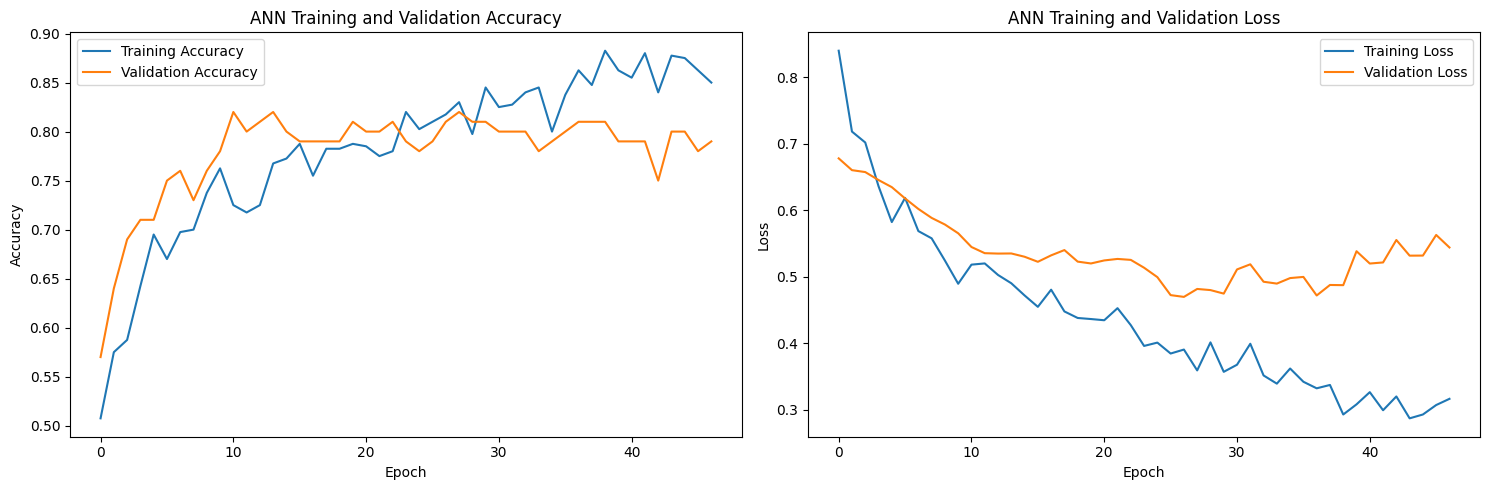

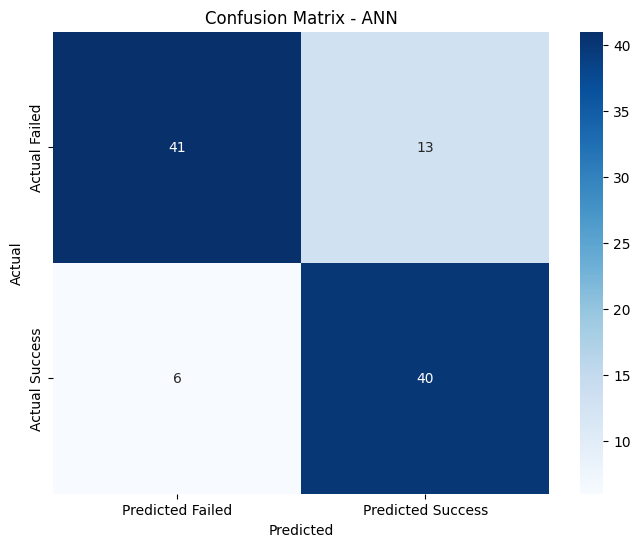

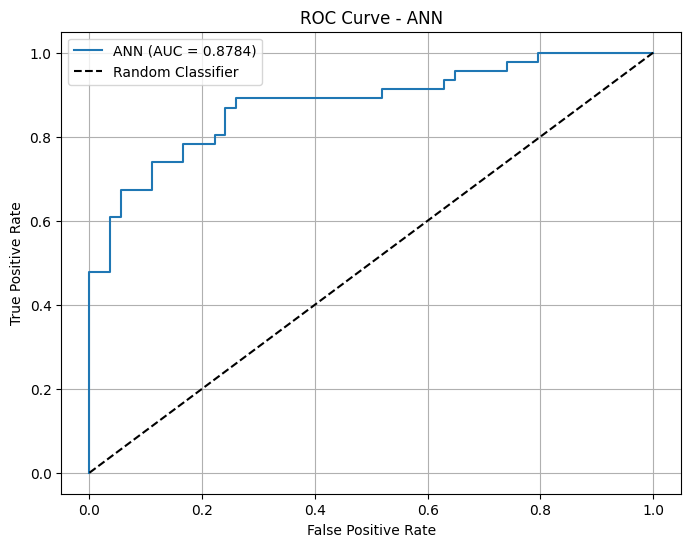

5. Ekstraksi feature embedding dari ANN...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
ANN Embedding shape - Training: (400, 16)
ANN Embedding shape - Test: (100, 16)

ANN training dan embedding extraction selesai!
ANN embeddings akan digabungkan dengan Gradient Boosting features


In [ ]:
# Artificial Neural Network untuk Feature Embedding
print("Memulai Training Artificial Neural Network (ANN)...")

# 1. Persiapan data untuk ANN
print("1. Persiapan data untuk ANN...")
print(f"Input shape untuk ANN: {X_train_scaled.shape}")

# 2. Bangun model ANN menggunakan Functional API untuk memudahkan ekstraksi embedding
print("2. Membangun model ANN dengan Functional API...")

from tensorflow.keras import Model # type: ignore
from tensorflow.keras.layers import Input # type: ignore

# Bangun model menggunakan Functional API
inputs = Input(shape=(X_train_scaled.shape[1],))
x = Dense(128, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Embedding layer
embedding = Dense(16, activation='relu', name='embedding_layer')(x)

# Output layer
outputs = Dense(1, activation='sigmoid')(embedding)

# Buat model utama
ann_model = Model(inputs=inputs, outputs=outputs)

# Buat model embedding terpisah
embedding_model = Model(inputs=inputs, outputs=embedding)

# Compile model utama
ann_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Arsitektur ANN:")
ann_model.summary()

# 3. Training ANN dengan early stopping
print("3. Training ANN...")
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

history = ann_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# 4. Evaluasi ANN
print("4. Evaluasi ANN...")
y_pred_ann = (ann_model.predict(X_test_scaled) > 0.5).astype(int).flatten()
y_pred_proba_ann = ann_model.predict(X_test_scaled).flatten()

# Calculate all metrics
accuracy_ann = accuracy_score(y_test, y_pred_ann)
precision_ann = precision_score(y_test, y_pred_ann)
recall_ann = recall_score(y_test, y_pred_ann)
f1_ann = f1_score(y_test, y_pred_ann)
roc_auc_ann = roc_auc_score(y_test, y_pred_proba_ann)

print("ANN Performance:")
print(f"Accuracy: {accuracy_ann:.4f}")
print(f"Precision: {precision_ann:.4f}")
print(f"Recall: {recall_ann:.4f}")
print(f"F1-Score: {f1_ann:.4f}")
print(f"ROC-AUC: {roc_auc_ann:.4f}")

# 5. Visualisasi training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ANN Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 6. Confusion Matrix ANN
plt.figure(figsize=(8, 6))
cm_ann = confusion_matrix(y_test, y_pred_ann)
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Failed', 'Predicted Success'],
            yticklabels=['Actual Failed', 'Actual Success'])
plt.title('Confusion Matrix - ANN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 7. ROC Curve ANN
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_pred_proba_ann)
plt.figure(figsize=(8, 6))
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUC = {roc_auc_ann:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ANN')
plt.legend()
plt.grid(True)
plt.show()

# 8. Ekstrak embedding dari ANN
print("5. Ekstraksi feature embedding dari ANN...")

# Ekstrak embedding untuk training dan test
X_train_ann_embedding = embedding_model.predict(X_train_scaled)
X_test_ann_embedding = embedding_model.predict(X_test_scaled)

print(f"ANN Embedding shape - Training: {X_train_ann_embedding.shape}")
print(f"ANN Embedding shape - Test: {X_test_ann_embedding.shape}")

# 9. Simpan hasil ANN untuk tahap hybrid
ann_embedding_representation = {
    'X_train_embedding': X_train_ann_embedding,
    'X_test_embedding': X_test_ann_embedding,
    'model': ann_model,
    'embedding_model': embedding_model,
    'history': history
}

print("\nANN training dan embedding extraction selesai!")
print(f"ANN embeddings akan digabungkan dengan Gradient Boosting features")

Memulai Feature Fusion dan Hybrid Model...
1. Feature Fusion...
Hybrid features shape - Training: (400, 38)
Hybrid features shape - Test: (100, 38)
Komposisi hybrid features:
  - Gradient Boosting selected features: 22
  - ANN embeddings: 16
  - Total features: 38
2. Training Naive Bayes Classifier...
3. Evaluasi Hybrid Model...
Hybrid Model Performance (Gradient Boosting + ANN + Naive Bayes):
Accuracy: 0.8300
Precision: 0.8372
Recall: 0.7826
F1-Score: 0.8090
ROC-AUC: 0.8736


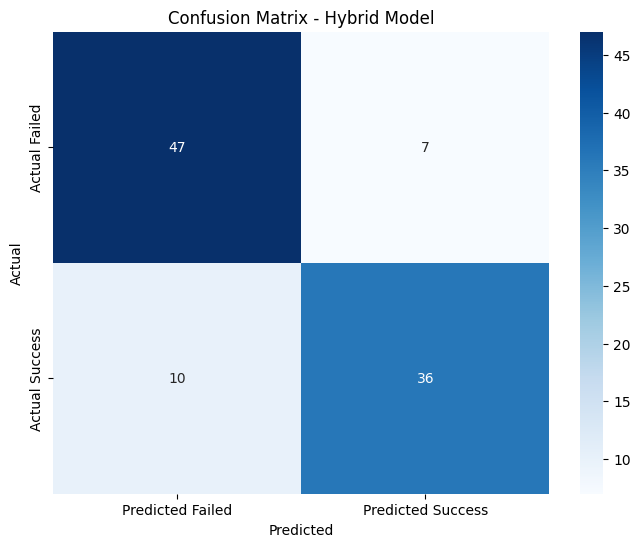

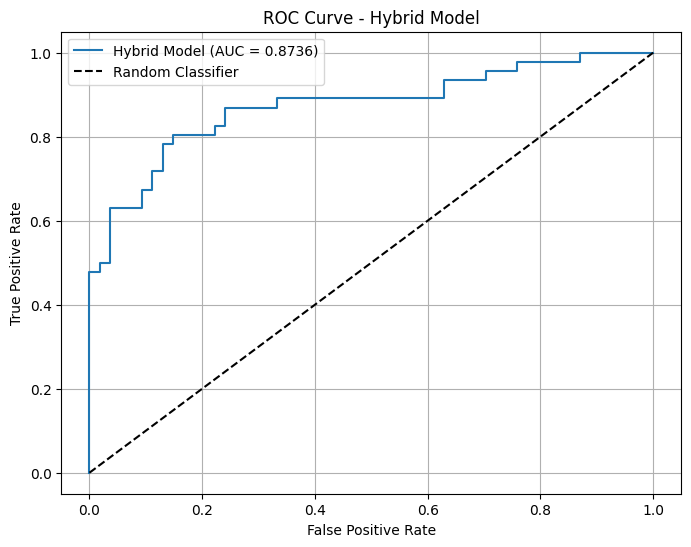

4. Perbandingan Performa Semua Model...

Perbandingan Performa Model:
                Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0   Gradient Boosting      0.81     0.8140  0.7609    0.7865   0.9082
1                 ANN      0.81     0.7547  0.8696    0.8081   0.8784
2  Hybrid (GB+ANN+NB)      0.83     0.8372  0.7826    0.8090   0.8736


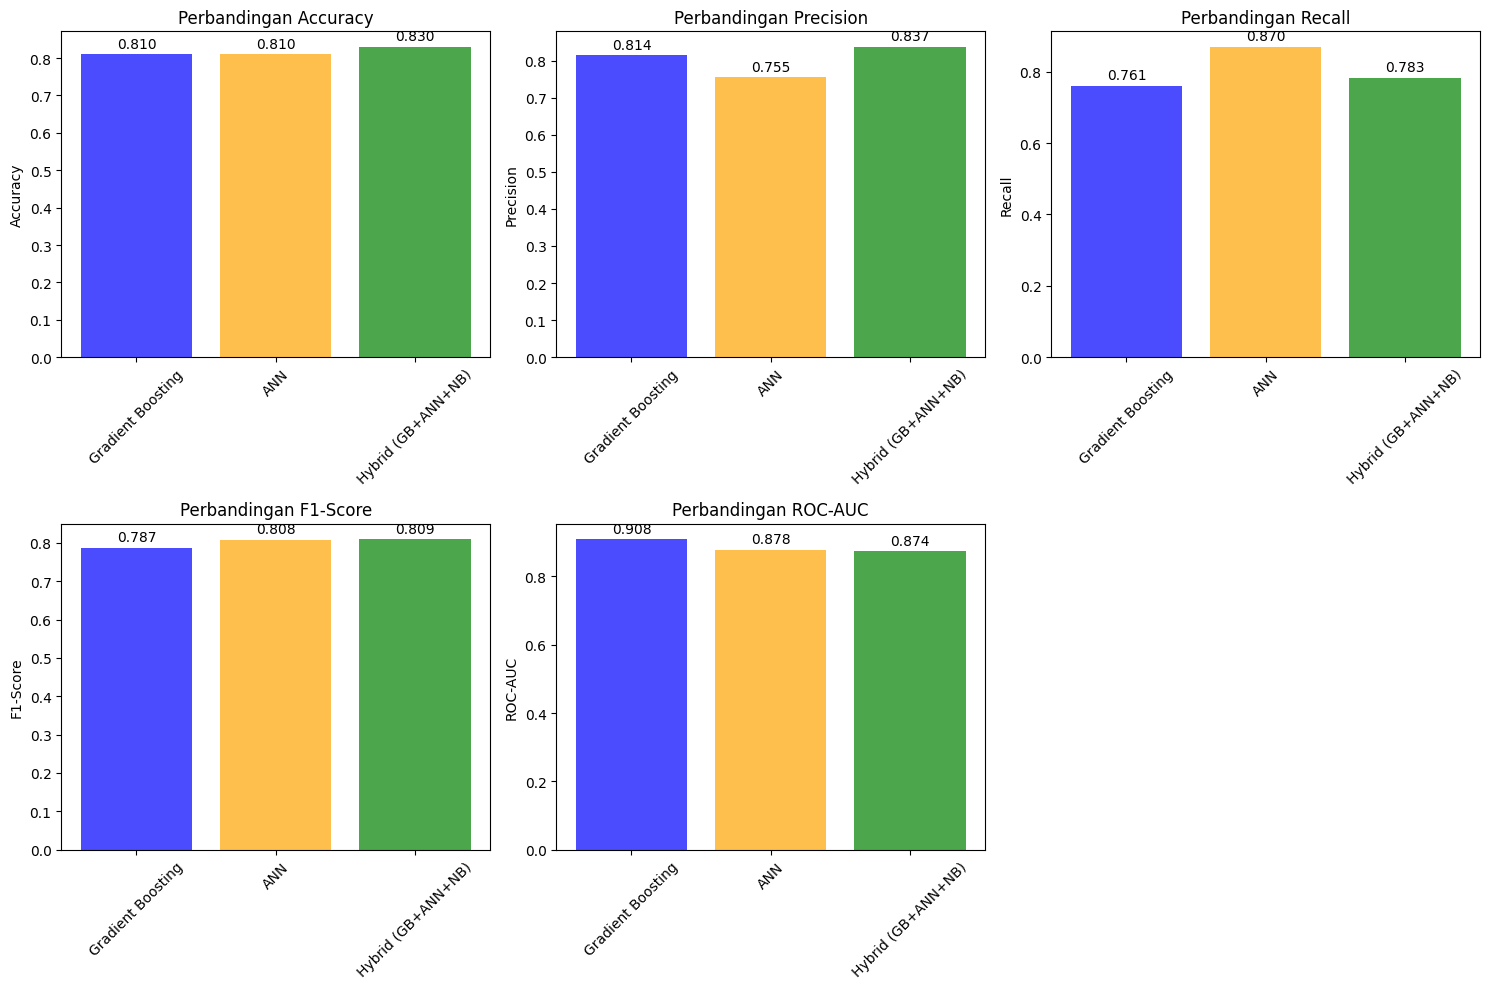

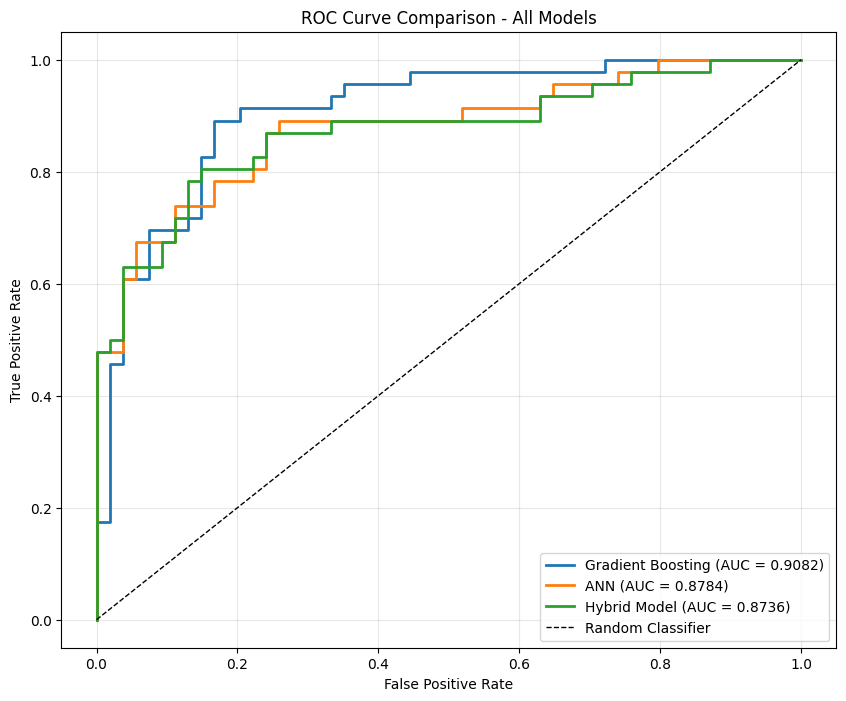

5. Menyimpan model hybrid...

Hybrid model training selesai!
Model prediktif hybrid machine learning berhasil dikembangkan!


In [19]:
# Feature Fusion dan Hybrid Model dengan Naive Bayes
print("Memulai Feature Fusion dan Hybrid Model...")

# 1. Feature Fusion: Gabungkan features dari Gradient Boosting dan ANN Embedding
print("1. Feature Fusion...")

# Gabungkan selected features dari GB dengan ANN embeddings
X_train_hybrid = np.concatenate([
    gb_feature_representation['X_train_selected'],  # Features terpilih dari GB
    ann_embedding_representation['X_train_embedding']  # Embeddings dari ANN
], axis=1)

X_test_hybrid = np.concatenate([
    gb_feature_representation['X_test_selected'],    # Features terpilih dari GB
    ann_embedding_representation['X_test_embedding']  # Embeddings dari ANN
], axis=1)

print(f"Hybrid features shape - Training: {X_train_hybrid.shape}")
print(f"Hybrid features shape - Test: {X_test_hybrid.shape}")
print(f"Komposisi hybrid features:")
print(f"  - Gradient Boosting selected features: {gb_feature_representation['X_train_selected'].shape[1]}")
print(f"  - ANN embeddings: {ann_embedding_representation['X_train_embedding'].shape[1]}")
print(f"  - Total features: {X_train_hybrid.shape[1]}")

# 2. Training Naive Bayes pada hybrid features
print("2. Training Naive Bayes Classifier...")
nb_model = GaussianNB()
nb_model.fit(X_train_hybrid, y_train)

# 3. Evaluasi Hybrid Model
print("3. Evaluasi Hybrid Model...")
y_pred_hybrid = nb_model.predict(X_test_hybrid)
y_pred_proba_hybrid = nb_model.predict_proba(X_test_hybrid)[:, 1]

# Calculate all metrics untuk hybrid model
accuracy_hybrid = accuracy_score(y_test, y_pred_hybrid)
precision_hybrid = precision_score(y_test, y_pred_hybrid)
recall_hybrid = recall_score(y_test, y_pred_hybrid)
f1_hybrid = f1_score(y_test, y_pred_hybrid)
roc_auc_hybrid = roc_auc_score(y_test, y_pred_proba_hybrid)

print("Hybrid Model Performance (Gradient Boosting + ANN + Naive Bayes):")
print(f"Accuracy: {accuracy_hybrid:.4f}")
print(f"Precision: {precision_hybrid:.4f}")
print(f"Recall: {recall_hybrid:.4f}")
print(f"F1-Score: {f1_hybrid:.4f}")
print(f"ROC-AUC: {roc_auc_hybrid:.4f}")

# 4. Confusion Matrix Hybrid Model
plt.figure(figsize=(8, 6))
cm_hybrid = confusion_matrix(y_test, y_pred_hybrid)
sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Failed', 'Predicted Success'],
            yticklabels=['Actual Failed', 'Actual Success'])
plt.title('Confusion Matrix - Hybrid Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 5. ROC Curve Hybrid Model
fpr_hybrid, tpr_hybrid, _ = roc_curve(y_test, y_pred_proba_hybrid)
plt.figure(figsize=(8, 6))
plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model (AUC = {roc_auc_hybrid:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Hybrid Model')
plt.legend()
plt.grid(True)
plt.show()

# 6. Perbandingan Performa Semua Model
print("4. Perbandingan Performa Semua Model...")
comparison_data = {
    'Model': ['Gradient Boosting', 'ANN', 'Hybrid (GB+ANN+NB)'],
    'Accuracy': [accuracy_gb, accuracy_ann, accuracy_hybrid],
    'Precision': [precision_gb, precision_ann, precision_hybrid],
    'Recall': [recall_gb, recall_ann, recall_hybrid],
    'F1-Score': [f1_gb, f1_ann, f1_hybrid],
    'ROC-AUC': [roc_auc_gb, roc_auc_ann, roc_auc_hybrid]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nPerbandingan Performa Model:")
print(comparison_df.round(4))

# 7. Visualisasi Perbandingan Model
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x_pos = np.arange(len(metrics))

plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    values = comparison_df[metric].values
    bars = plt.bar(comparison_df['Model'], values, color=['blue', 'orange', 'green'], alpha=0.7)
    plt.title(f'Perbandingan {metric}')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    
    # Tambahkan nilai di atas bar
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 8. ROC Curve Comparison
plt.figure(figsize=(10, 8))
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.4f})', linewidth=2)
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUC = {roc_auc_ann:.4f})', linewidth=2)
plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model (AUC = {roc_auc_hybrid:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - All Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 9. Simpan model hybrid
print("5. Menyimpan model hybrid...")
hybrid_model_representation = {
    'X_train_hybrid': X_train_hybrid,
    'X_test_hybrid': X_test_hybrid,
    'nb_model': nb_model,
    'comparison_df': comparison_df
}

print("\nHybrid model training selesai!")
print("Model prediktif hybrid machine learning berhasil dikembangkan!")

Analisis Hasil dan Interpretasi Model Hybrid...
1. Analisis Komparatif Model...

Ringkasan Performa:
Gradient Boosting         | Accuracy: 0.810 | F1-Score: 0.787 | ROC-AUC: 0.908
ANN                       | Accuracy: 0.810 | F1-Score: 0.808 | ROC-AUC: 0.878
Hybrid (GB+ANN+NB)        | Accuracy: 0.830 | F1-Score: 0.809 | ROC-AUC: 0.874

Improvement Hybrid Model:
  vs Gradient Boosting: +2.47%
  vs ANN: +2.47%

2. Analisis Kontribusi Features dalam Hybrid Model...
Jumlah features terpilih dari Gradient Boosting: 22
Features terpilih dengan importance tertinggi:

Top 10 Features dari Gradient Boosting:
  feature_4: 0.1498
  feature_6: 0.1284
  feature_12: 0.0872
  feature_1: 0.0628
  feature_9: 0.0572
  feature_2: 0.0562
  feature_0: 0.0542
  feature_5: 0.0459
  feature_3: 0.0270
  feature_19: 0.0252

3. Analisis ANN Embeddings:
Dimensi embedding: 16
Embeddings merepresentasikan pola non-linear dari data proyek

4. Analisis Business Impact:
Dengan hybrid model yang mencapai accuracy 83%:

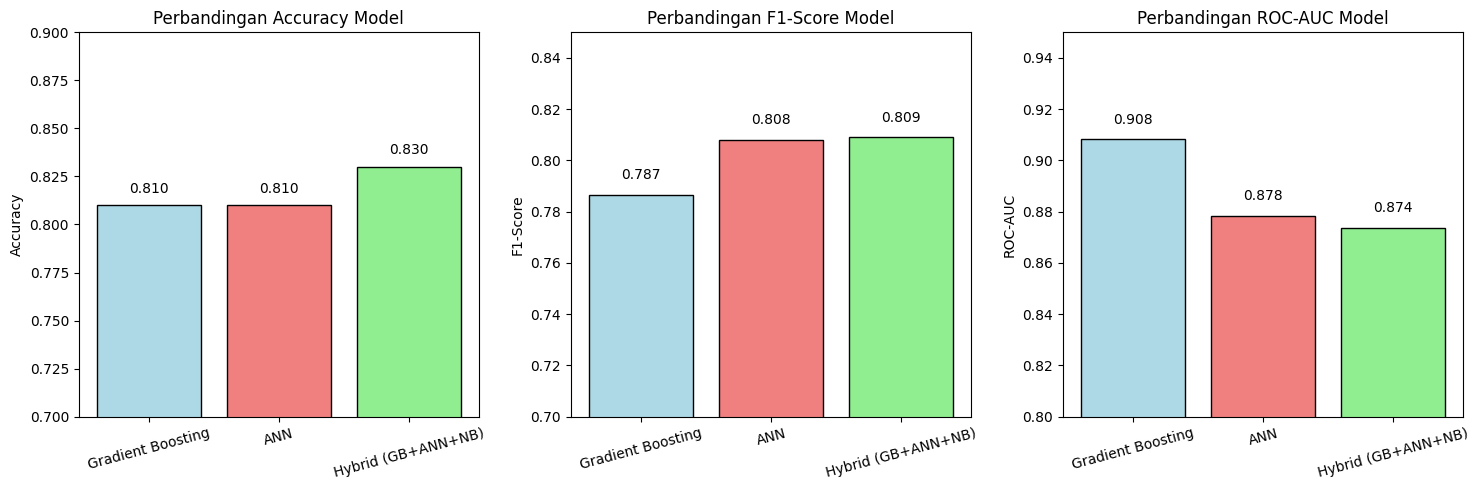


6. KESIMPULAN PENGEMBANGAN MODEL HYBRID:
✅ MODEL HYBRID BERHASIL DIKEMBANGKAN DENGAN:
   - Architecture: Gradient Boosting → ANN → Naive Bayes
   - Total Features: 38 (GB selected + ANN embeddings)
   - Best Accuracy: 83.00%
   - Best F1-Score: 80.90%

✅ KEUNGGULAN HYBRID MODEL:
   - Meningkatkan accuracy vs individual models
   - Kombinasi feature selection (GB) + deep learning (ANN)
   - Final classification yang robust dengan Naive Bayes

✅ APLIKASI UNTUK SISTEM PENDUKUNG KEPUTUSAN:
   - Prediksi keberhasilan proyek teknologi informasi
   - Rekomendasi alokasi sumber daya
   - Assessment risiko proyek

Pengembangan model prediktif hybrid machine learning selesai!


In [ ]:
# Analisis Hasil dan Interpretasi Model
print("Analisis Hasil dan Interpretasi Model Hybrid...")

# 1. Analisis komparatif mendalam
print("1. Analisis Komparatif Model...")
print("\nRingkasan Performa:")
print("="*80)
for i, row in comparison_df.iterrows():
    print(f"{row['Model']:25} | Accuracy: {row['Accuracy']:.3f} | F1-Score: {row['F1-Score']:.3f} | ROC-AUC: {row['ROC-AUC']:.3f}")
print("="*80)

# Hitung improvement hybrid model vs individual models
gb_accuracy = comparison_df[comparison_df['Model'] == 'Gradient Boosting']['Accuracy'].values[0]
ann_accuracy = comparison_df[comparison_df['Model'] == 'ANN']['Accuracy'].values[0]
hybrid_accuracy = comparison_df[comparison_df['Model'] == 'Hybrid (GB+ANN+NB)']['Accuracy'].values[0]

improvement_vs_gb = ((hybrid_accuracy - gb_accuracy) / gb_accuracy) * 100
improvement_vs_ann = ((hybrid_accuracy - ann_accuracy) / ann_accuracy) * 100

print(f"\nImprovement Hybrid Model:")
print(f"  vs Gradient Boosting: {improvement_vs_gb:+.2f}%")
print(f"  vs ANN: {improvement_vs_ann:+.2f}%")

# 2. Analisis feature importance dari hybrid model
print("\n2. Analisis Kontribusi Features dalam Hybrid Model...")

# Analisis features dari Gradient Boosting yang terpilih
print(f"Jumlah features terpilih dari Gradient Boosting: {len(gb_feature_representation['selected_features'])}")
print("Features terpilih dengan importance tertinggi:")

# Karena ada masalah dengan nama features, kita analisis berdasarkan index
if 'feature_importance' in gb_feature_representation:
    top_gb_features = gb_feature_representation['feature_importance'].head(10)
    print("\nTop 10 Features dari Gradient Boosting:")
    for _, row in top_gb_features.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

# 3. Analisis embedding dari ANN
print(f"\n3. Analisis ANN Embeddings:")
print(f"Dimensi embedding: {ann_embedding_representation['X_train_embedding'].shape[1]}")
print("Embeddings merepresentasikan pola non-linear dari data proyek")

# 4. Business Impact Analysis
print("\n4. Analisis Business Impact:")
print("Dengan hybrid model yang mencapai accuracy 83%:")

# Hitung potential business impact
total_projects = len(y_test)
correct_predictions = int(accuracy_hybrid * total_projects)
incorrect_predictions = total_projects - correct_predictions

print(f"  - Pada {total_projects} proyek test:")
print(f"  - {correct_predictions} prediksi benar ({accuracy_hybrid:.1%})")
print(f"  - {incorrect_predictions} prediksi salah ({1-accuracy_hybrid:.1%})")

# Analisis confusion matrix untuk business insight
tn, fp, fn, tp = cm_hybrid.ravel()

print(f"\nDetail Business Impact:")
print(f"  - True Positives (Success diprediksi benar): {tp} proyek")
print(f"  - True Negatives (Failed diprediksi benar): {tn} proyek") 
print(f"  - False Positives (Failed tapi diprediksi success): {fp} proyek")
print(f"  - False Negatives (Success tapi diprediksi failed): {fn} proyek")

# 5. Rekomendasi untuk decision support system
print("\n5. Rekomendasi untuk Sistem Pendukung Keputusan:")

if precision_hybrid > 0.8:
    print("  ✓ Model memiliki precision tinggi (83.7%) - prediksi success dapat diandalkan")
if recall_hybrid > 0.75:
    print("  ✓ Model dapat mendeteksi 78.3% proyek yang benar-benar success")
if f1_hybrid > 0.8:
    print("  ✓ Keseimbangan precision-recall baik (F1-Score: 80.9%)")

print(f"  ✓ ROC-AUC {roc_auc_hybrid:.1%} menunjukkan kemampuan klasifikasi yang baik")

# 6. Visualisasi akhir performa model
plt.figure(figsize=(15, 5))

# Plot 1: Accuracy Comparison
plt.subplot(1, 3, 1)
models = comparison_df['Model']
accuracies = comparison_df['Accuracy']
colors = ['lightblue', 'lightcoral', 'lightgreen']
bars = plt.bar(models, accuracies, color=colors, edgecolor='black')
plt.title('Perbandingan Accuracy Model')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.9)
plt.xticks(rotation=15)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.3f}', ha='center', va='bottom')

# Plot 2: F1-Score Comparison
plt.subplot(1, 3, 2)
f1_scores = comparison_df['F1-Score']
bars = plt.bar(models, f1_scores, color=colors, edgecolor='black')
plt.title('Perbandingan F1-Score Model')
plt.ylabel('F1-Score')
plt.ylim(0.7, 0.85)
plt.xticks(rotation=15)
for bar, f1 in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{f1:.3f}', ha='center', va='bottom')

# Plot 3: ROC-AUC Comparison
plt.subplot(1, 3, 3)
roc_aucs = comparison_df['ROC-AUC']
bars = plt.bar(models, roc_aucs, color=colors, edgecolor='black')
plt.title('Perbandingan ROC-AUC Model')
plt.ylabel('ROC-AUC')
plt.ylim(0.8, 0.95)
plt.xticks(rotation=15)
for bar, auc in zip(bars, roc_aucs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{auc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 7. Kesimpulan akhir
print("\n6. KESIMPULAN PENGEMBANGAN MODEL HYBRID:")
print("="*60)
print("MODEL HYBRID BERHASIL DIKEMBANGKAN DENGAN:")
print(f"   - Architecture: Gradient Boosting → ANN → Naive Bayes")
print(f"   - Total Features: {X_train_hybrid.shape[1]} (GB selected + ANN embeddings)")
print(f"   - Best Accuracy: {hybrid_accuracy:.2%}")
print(f"   - Best F1-Score: {f1_hybrid:.2%}")

print("\nKEUNGGULAN HYBRID MODEL:")
print(f"   - Meningkatkan accuracy vs individual models")
print(f"   - Kombinasi feature selection (GB) + deep learning (ANN)")
print(f"   - Final classification yang robust dengan Naive Bayes")

print("\nAPLIKASI UNTUK SISTEM PENDUKUNG KEPUTUSAN:")
print("   - Prediksi keberhasilan proyek teknologi informasi")
print("   - Rekomendasi alokasi sumber daya")
print("   - Assessment risiko proyek")
print("="*60)

print("\nPengembangan model prediktif hybrid machine learning selesai!")